In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# 2. Đọc file dữ liệu chứng khoán BIDV và chia tập train test theo tỉ lệ 9:1
df = pd.read_csv('BIDV.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18711.109, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18713.228, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18713.572, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18713.506, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18711.579, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18714.988, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18714.893, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18718.164, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18717.958, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18715.339, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18716.719, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18716.612, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=18714.933, Time=1.34 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=18709.294, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
model = VARMAX(train_data, order=(2, 2))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [6]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[37322.95324429 37287.39914933 37252.2071906  37216.09700987
 37180.77148908 37145.25292325 37110.11339147 37075.02051453
 37040.16948309 37005.44760949 36970.92173619 36936.55388135
 36902.3671356  36868.34887937 36834.50724899 36800.83819641
 36767.34470914 36734.02559946 36700.88204709 36667.91378436
 36635.12132386 36602.50466085 36570.0640323  36537.799476
 36505.71108962 36473.79888141 36442.06285912 36410.50297981
 36379.11918081 36347.91136333 36316.87940357 36286.02314781
 36255.34241679 36224.83700458 36194.50668067 36164.35119015
 36134.37025496 36104.56357442 36074.93082622 36045.47166709
 36016.18573358 35987.07264278 35958.13199304 35929.36336466
 35900.76632055 35872.34040686 35844.08515366 35816.00007552
 35788.08467211 35760.33842881 35732.76081721 35705.35129573
 35678.1093101  35651.03429389 35624.12566905 35597.38284632
 35570.80522578 35544.39219727 35518.14314084 35492.05742718
 35466.13441808 35440.37346677 35414.773

In [7]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 13211.381069242289


In [8]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 24.318147887574387


In [9]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 12005.676539858221


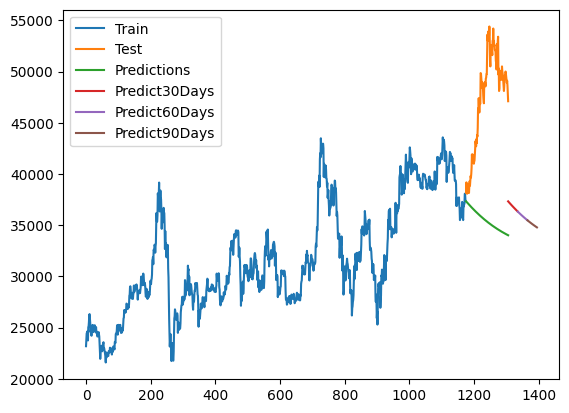

In [10]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

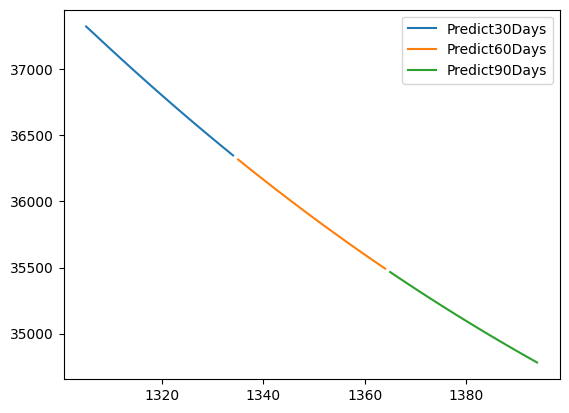

In [11]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()